# Predicción de Lluvia en Australia

### Facultad de Ciencias Exactas, Ingeniería y Agrimensura  
### Tecnicatura en Inteligencia Artificial  
### Aprendizaje Automático 1  

**Trabajo Práctico**: Predicción de lluvia utilizando modelos de clasificación y redes neuronales.

**Autores**:  
- Avecilla Tomas 
- Calcia Franco  

 

---

### Objetivo
Desarrollar un modelo de predicción de la variable `RainTomorrow` basado en datos climáticos de Australia, utilizando técnicas de pre-procesamiento, modelado, evaluación y optimización de modelos, para su posterior puesta en producción.



### Diccionario de Datos

| Variable         | Descripción                                                       | Tipo        | Ejemplo       
|-------------------|------------------------------------------------------------------|-------------|---------------
| **Date**          | Fecha de la observación del clima.                               | object      | 2010-01-01    
| **Location**      | Ciudad donde se realizó la medición del clima.                  | object      | Sydney        
| **MinTemp**       | Temperatura mínima del día (en grados Celsius).                 | float64     | 12.3          
| **MaxTemp**       | Temperatura máxima del día (en grados Celsius).                 | float64     | 28.9          
| **Rainfall**      | Cantidad de lluvia caída en milímetros durante el día.          | float64     | 0.0           
| **Evaporation**   | Evaporación en milímetros durante el día.                       | float64     | 0.0           
| **Sunshine**      | Horas de sol durante el día.                                    | float64     | 8.0           
| **WindGustDir**   | Dirección del viento racheado (en grados).                      | object      | NNE           
| **WindGustSpeed** | Velocidad del viento racheado (en km/h).                        | float64     | 15.0          
| **WindDir9am**    | Dirección del viento a las 9 am.                                | object      | NNE           
| **WindDir3pm**    | Dirección del viento a las 3 pm.                                | object      | SSE          
| **WindSpeed9am**  | Velocidad del viento a las 9 am (en km/h).                     | float64     | 5.0           
| **WindSpeed3pm**  | Velocidad del viento a las 3 pm (en km/h).                     | float64     | 10.0          
| **Humidity9am**   | Humedad relativa a las 9 am (%).                               | float64     | 65.0          
| **Humidity3pm**   | Humedad relativa a las 3 pm (%).                               | float64     | 55.0          
| **Pressure9am**   | Presión atmosférica a las 9 am (hPa).                          | float64     | 1012.0        
| **Pressure3pm**   | Presión atmosférica a las 3 pm (hPa).                          | float64     | 1011.0        
| **Cloud9am**      | Cobertura nubosa a las 9 am (en octavos).                      | float64     | 2.0           
| **Cloud3pm**      | Cobertura nubosa a las 3 pm (en octavos).                      | float64     | 3.0           
| **Temp9am**       | Temperatura a las 9 am (en grados Celsius).                    | float64     | 15.0          
| **Temp3pm**       | Temperatura a las 3 pm (en grados Celsius).                    | float64     | 20.0          
| **RainToday**     | Indica si llovió hoy (Yes/No).                                 | object      | Yes           
| **RainTomorrow** _(Target)_ | Indica si lloverá mañana (Yes/No).                             | object      | No            


## Preparación del entorno de trabajo

In [2]:
!pip install tpot
!pip install shap

In [3]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import RobustScaler
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from tpot import TPOTClassifier

c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [4]:
df_clima = pd.read_csv("weatherAUS.csv")

In [5]:
ciudades_aleatorias = df_clima['Location'].sample(n=10, random_state=37)
df_filtered = df_clima[df_clima['Location'].isin(ciudades_aleatorias)]
df_filtered['Location'].value_counts()

Location
Canberra        3436
Albury          3040
Bendigo         3040
Penrith         3039
Tuggeranong     3039
Woomera         3009
PearceRAAF      3009
PerthAirport    3009
Walpole         3006
Uluru           1578
Name: count, dtype: int64

## Análisis Descriptivo

In [6]:
df_filtered.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [7]:
# Resumen de estadísticas descriptivas
stats = df_filtered.describe().T
stats['missing_values'] = df_filtered.isnull().sum()
stats = stats.round(2)
stats.head(35)


,count,mean,std,min,25%,50%,75%,max,missing_values
MinTemp,29061.0,10.68,6.24,-8.2,6.40,10.8,15.1,31.8,144
MaxTemp,29087.0,23.62,7.46,2.6,17.80,22.7,28.8,48.1,118
Rainfall,28528.0,1.76,5.88,0.0,0.00,0.0,0.2,115.4,677
Evaporation,8595.0,6.48,5.96,0.0,2.60,5.0,8.8,82.4,20610
Sunshine,9536.0,8.63,3.48,0.0,6.48,9.3,11.3,14.2,19669
WindGustSpeed,28319.0,39.06,13.39,7.0,30.00,39.0,46.0,135.0,886
WindSpeed9am,28801.0,12.83,8.89,0.0,6.00,11.0,19.0,57.0,404
WindSpeed3pm,28834.0,17.42,8.25,0.0,11.00,17.0,22.0,67.0,371
Humidity9am,28899.0,67.03,20.45,0.0,54.00,69.0,82.0,100.0,306
Humidity3pm,28982.0,44.91,20.75,0.0,29.00,44.0,58.0,100.0,223


**Descripción rápida de los datos:**
Este conjunto de datos contiene información meteorológica con un número considerable de valores faltantes. Algunas variables como la evaporación, la luz solar y la cobertura nubosa tienen un porcentaje elevado de datos faltantes, mientras que otras, como la temperatura y la humedad, tienen menos valores nulos.

In [8]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29205 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           29205 non-null  object 
 1   Location       29205 non-null  object 
 2   MinTemp        29061 non-null  float64
 3   MaxTemp        29087 non-null  float64
 4   Rainfall       28528 non-null  float64
 5   Evaporation    8595 non-null   float64
 6   Sunshine       9536 non-null   float64
 7   WindGustDir    28284 non-null  object 
 8   WindGustSpeed  28319 non-null  float64
 9   WindDir9am     26179 non-null  object 
 10  WindDir3pm     28606 non-null  object 
 11  WindSpeed9am   28801 non-null  float64
 12  WindSpeed3pm   28834 non-null  float64
 13  Humidity9am    28899 non-null  float64
 14  Humidity3pm    28982 non-null  float64
 15  Pressure9am    25833 non-null  float64
 16  Pressure3pm    25843 non-null  float64
 17  Cloud9am       13681 non-null  float64
 18  Cloud3pm  

El DataFrame contiene 23 columnas, de las cuales 16 son de tipo numérico (float64) y 7 de tipo categórico (object). Como primer paso, convertiremos el tipo de dato de la columna 'Date' a un formato de fecha adecuado y luego ordenaremos el dataset en orden ascendente.

In [9]:
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

df_filtered = df_filtered.sort_values(by='Date', ascending=True)

C:\Users\franco\AppData\Local\Temp\ipykernel_11296\4025393556.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])


In [10]:

df_filtered = pd.get_dummies(df_filtered, columns=['RainToday', 'RainTomorrow'], drop_first=True)
# Renombrar las columnas
df_filtered = df_filtered.rename(columns={'RainToday_Yes': 'RainToday', 'RainTomorrow_Yes': 'RainTomorrow'})
# Convertir las columnas RainToday y RainTomorrow a 0 y 1
df_filtered['RainToday'] = df_filtered['RainToday'].astype(int)
df_filtered['RainTomorrow'] = df_filtered['RainTomorrow'].astype(int)

Vamos a analizar el comportamiento de nuestras variables numéricas para identificar tendencias o distribuciones. 

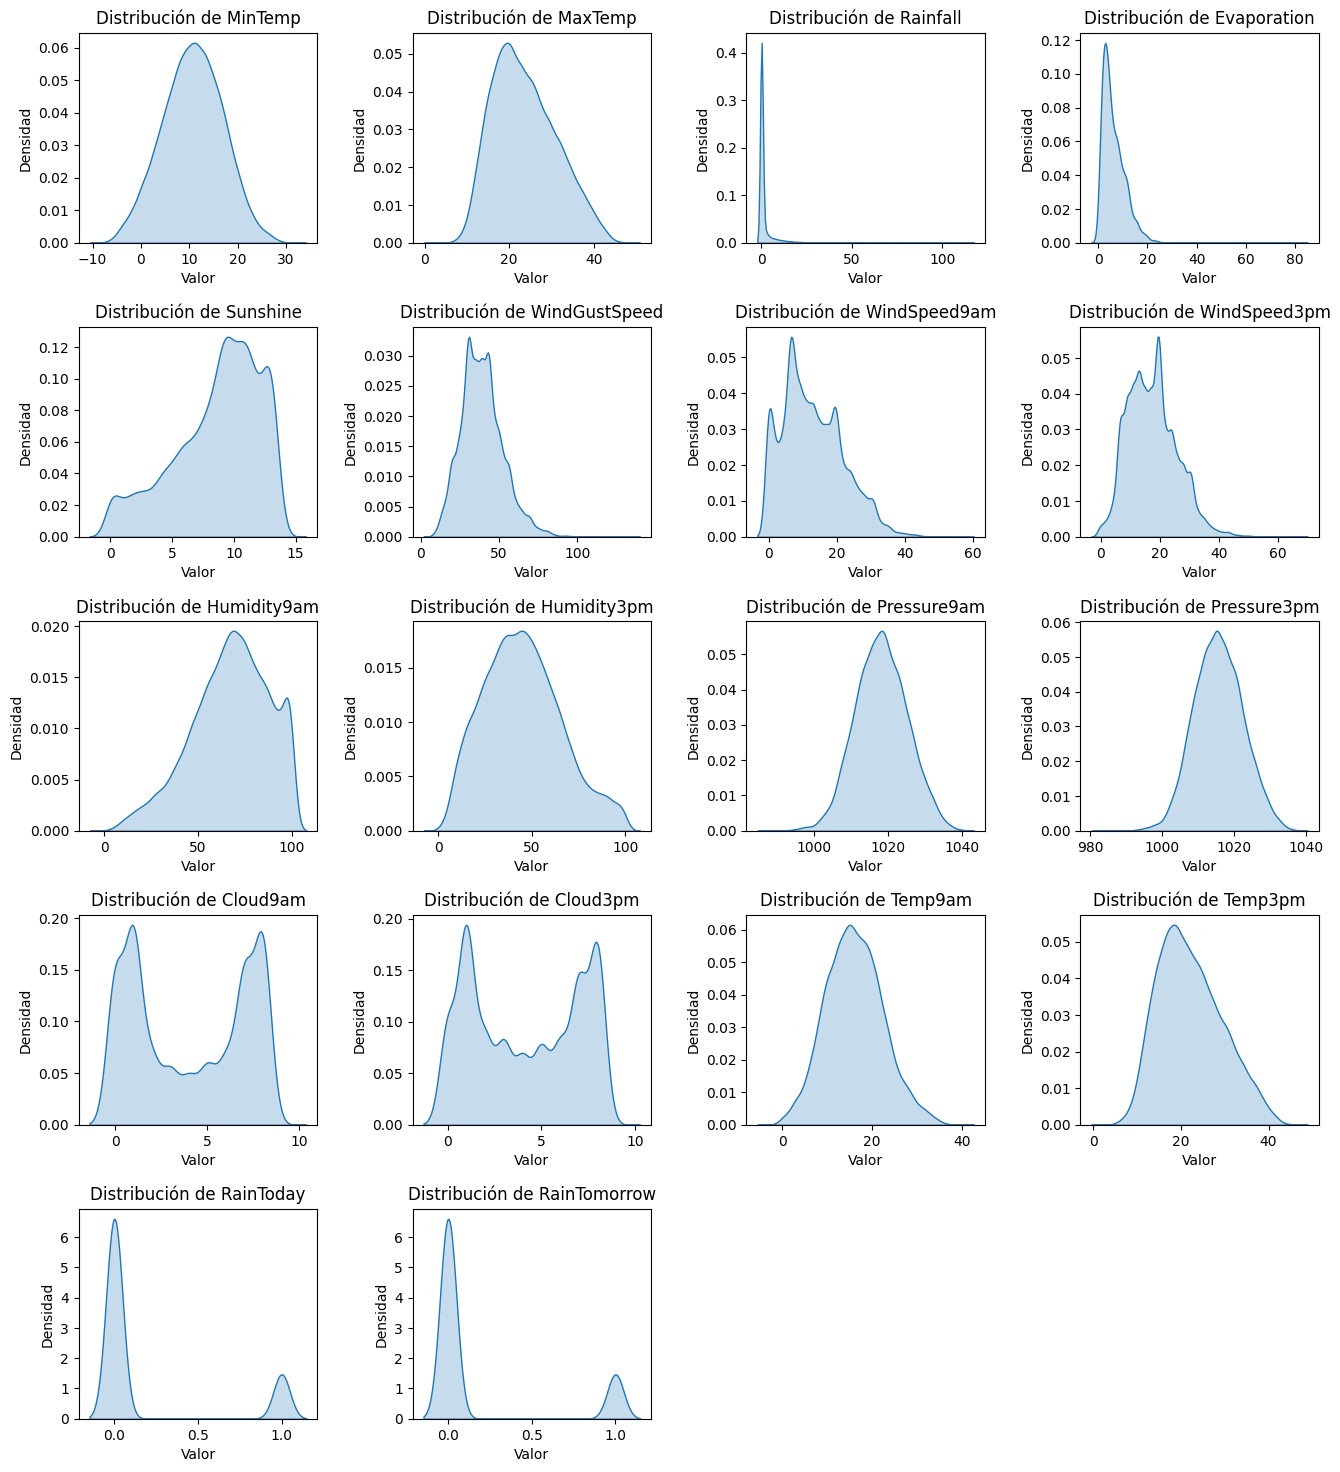

In [11]:
# Filtrar las columnas numéricas del dataframe
df_numerico = df_filtered.select_dtypes(include=['float64', 'int64'])

# Determinar el número de variables numéricas
num_vars = len(df_numerico.columns)

# Configurar la figura y las subplots
fig, axes = plt.subplots(nrows=(num_vars // 4) + (num_vars % 4 > 0), ncols=4, figsize=(16, num_vars))

# Ajustar espacio entre los gráficos
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Recorrer las columnas y plotear cada una en su propio subplot
for i, column in enumerate(df_numerico.columns):
    row, col = divmod(i, 4)
    sns.kdeplot(df_numerico[column], ax=axes[row, col], fill=True)
    axes[row, col].set_title(f'Distribución de {column}')
    axes[row, col].set_xlabel('Valor')
    axes[row, col].set_ylabel('Densidad')

# Eliminar gráficos vacíos si no se llena la última fila
for j in range(i + 1, axes.size):
    fig.delaxes(axes.flat[j])

plt.show()


Al analizar las distribuciones de las variables numéricas a través de gráficos de KDE, observamos varios patrones.

1. **Distribuciones Normales**:
   Algunas variables muestran una distribución simétrica, similar a la curva de campana característica de la **distribución normal**.

2. **Distribuciones Asimétricas (Sesgo)**:
   Otras variables presentan **sesgo**, ya sea positivo o negativo..
   
   - **Implicación**: Estas variables pueden requerir transformaciones para mejorar su simetría. Esto facilitará la aplicabilidad para los modelos.

3. **Distribuciones Multimodales**:
   Se observan algunas variables con **distribuciones multimodales**, es decir, con varios picos en su densidad. Esto podría sugerir la existencia de **subgrupos** lo cual es normal ya que los datos son climaticos y puede llegar a tener algo que ver con las estaciones.

4. **Presencia de Outliers**:
   Varias variables muestran distribuciones con **colas largas**, lo que indica la presencia de **outliers** lo cual nos confirma lo que fue analizado anteriormente.



## Analisis exploratorio

Viendo que las columnas 'WindGustDir', 'WindDir9am' y 'WindDir3pm' son variables categóricas (tipo object), evaluaremos su correlación con nuestra variable objetivo. Esto nos ayudará a decidir si es conveniente eliminarlas o mantenerlas, con el objetivo de reducir la complejidad del modelo y evitar posibles problemas en la etapa de predicción.

C:\Users\franco\AppData\Local\Temp\ipykernel_11296\3675620961.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations_with_rain.index, y=correlations_with_rain.values, palette='coolwarm')


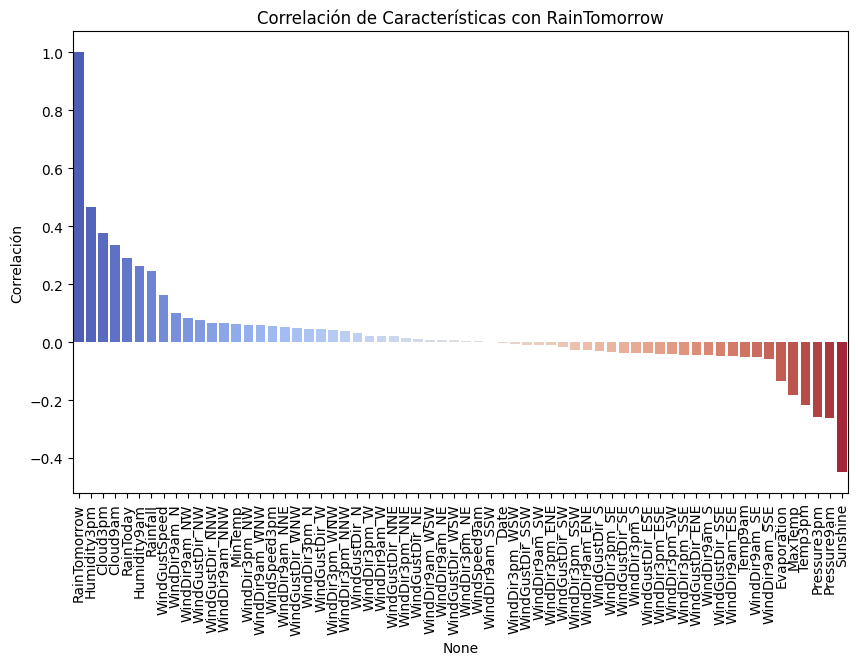

In [12]:
# Eliminar la columna 'Location'
df_without_location = df_filtered.drop(columns=['Location'])
# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df_without_location, columns=['WindGustDir', 'WindDir9am', 'WindDir3pm'], drop_first=True)

# Calcular la matriz de correlación
correlation_matrix = df_encoded.corr()

# Mostrar correlación con 'RainTomorrow'
# Ordenar las correlaciones con 'RainTomorrow'
correlations_with_rain = correlation_matrix['RainTomorrow'].sort_values(ascending=False)

# Crear un gráfico de barras para visualizar la correlación de cada característica con 'RainTomorrow'
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_with_rain.index, y=correlations_with_rain.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Correlación de Características con RainTomorrow')
plt.ylabel('Correlación')
plt.show()

Es evidente que estas variables no tendrían un impacto significativo en el rendimiento del modelo. Por lo tanto, procederemos a eliminarlas para simplificar el conjunto de datos y evitar complicaciones en el proceso de predicción.

In [13]:
columnas = ['WindDir9am', 'WindDir3pm', 'WindGustDir']

# Dropear las columnas
df_filtered = df_filtered.drop(columns=columnas)

Para la variable categórica 'Location', calculamos la proporción de cada localidad en relación con nuestra variable objetivo. Esto nos permitió evaluar cómo cada ubicación podría influir en la predicción.

In [14]:
df_filtered['Location'] = df_filtered['Location'].fillna('Categoria_Nula')

mean_encoded_location_today = df_filtered.groupby('Location')['RainTomorrow'].mean()

df_filtered['Location'] = df_filtered['Location'].map(mean_encoded_location_today)

Al observar los valores faltantes, calculamos el porcentaje de datos faltantes en cada columna. 

In [15]:
conteo_nan = df_filtered.isnull().sum()
# Que porcentaje del total de cada columna hay valores faltantes
nan_percentage = (conteo_nan / len(df_filtered)) * 100
missing_data = pd.DataFrame({'count': conteo_nan, 'percentage': nan_percentage})
print(missing_data)

               count  percentage
Date               0    0.000000
Location           0    0.000000
MinTemp          144    0.493066
MaxTemp          118    0.404040
Rainfall         677    2.318096
Evaporation    20610   70.570108
Sunshine       19669   67.348057
WindGustSpeed    886    3.033727
WindSpeed9am     404    1.383325
WindSpeed3pm     371    1.270330
Humidity9am      306    1.047766
Humidity3pm      223    0.763568
Pressure9am     3372   11.545968
Pressure3pm     3362   11.511727
Cloud9am       15524   53.155282
Cloud3pm       15684   53.703133
Temp9am          151    0.517035
Temp3pm          110    0.376648
RainToday          0    0.000000
RainTomorrow       0    0.000000


Algunas variables, como 'Evaporation', 'Sunshine', 'Cloud9am' y 'Cloud3pm', tienen un porcentaje considerable de datos faltantes, mientras que otras, como 'MinTemp', 'MaxTemp' o 'Rainfall', presentan menos valores faltantes.

### Limpieza de Datos

Como primera medida, eliminaremos las filas que tengan valores nulos en la variable objetivo o aquellas que presenten 18 o más columnas con valores nulos, ya que las consideramos irrelevantes para el análisis.

In [16]:
#Mantenemos las filas que contengan 18 o menos valores nulos
df_filtered = df_filtered.dropna(thresh=18)

#Eliminamos las filas que contienen la variable Target como nula
df_filtered = df_filtered.dropna(subset=['RainTomorrow'])

A continuación, realizaremos la división de los datos, ya que consideramos que es un paso necesario en este punto. Sin embargo, continuaremos con el análisis exploratorio y la limpieza de los datos una vez realizada esta división.

### Train-Test

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_filtered.drop(columns=['RainTomorrow']), df_filtered['RainTomorrow'], test_size=0.3, random_state=42)

#Validacion
X_train, X_temp, y_train, y_temp = train_test_split(
    df_filtered.drop(columns=['RainTomorrow']),
    df_filtered['RainTomorrow'],
    test_size=0.3,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5, 
    random_state=42
)

# Concatenar para tener dataframes completos
df_entrenamiento = pd.concat([X_train, y_train], axis=1)
df_validacion = pd.concat([X_val, y_val], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

Decidimos imputar las variables que tienen menos de 1000 valores faltantes utilizando la media, ya que el porcentaje que representan en relación con el total de filas es insignificante y no debería afectar el análisis o los resultados del modelo de manera considerable.

In [18]:
# Identificar las columnas con menos de 1000 nulos
cols_with_few_nans = df_entrenamiento.columns[df_entrenamiento.isnull().sum() < 1000]
medias = {}

for col in cols_with_few_nans:
    if df_entrenamiento[col].dtype in ['float64', 'int64']:  # Solo columnas numéricas
        media = df_entrenamiento[col].mean()  # Calcular la media
        df_entrenamiento[col] = df_entrenamiento[col].fillna(media) 
        medias[col] = media


In [19]:
nan_count_train = df_entrenamiento.isnull().sum()
nan_count_train

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation      3372
Sunshine         3143
WindGustSpeed       0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
dtype: int64

Todavia contamos con columnas que presentan algunos valores nulos. Antes de tomar decisiones sobre cómo manejarlas, analizaremos su distribución para evaluar si es conveniente imputarlas o eliminarlas, con el fin de tomar una decisión informada que no afecte negativamente el análisis o el rendimiento del modelo.

<Axes: xlabel='Evaporation', ylabel='Density'>

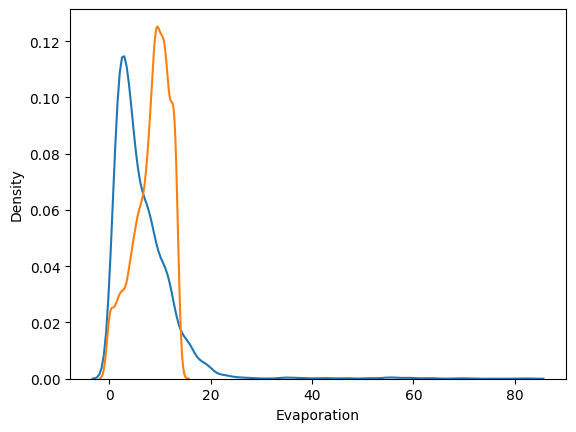

In [20]:
sns.kdeplot(df_entrenamiento["Evaporation"])
sns.kdeplot(df_entrenamiento["Sunshine"])

Podemos observar una clara distribución asimétrica a la derecha. Por lo tanto, optaremos por imputar los valores nulos utilizando la mediana, ya que este enfoque es más robusto frente a los valores atípicos y proporciona una estimación más representativa de los datos.

In [21]:
# Imputar los valores faltantes en 'Evaporation' y 'Sunshine' con la mediana
mediana_evaporation = df_entrenamiento['Evaporation'].median()
mediana_sunshine= df_entrenamiento['Sunshine'].median()

df_entrenamiento['Evaporation'] = df_entrenamiento['Evaporation'].fillna(mediana_evaporation)
df_entrenamiento['Sunshine'] = df_entrenamiento['Sunshine'].fillna(mediana_sunshine)


Aplicamos lo mismo para las demás columnas.

<Axes: xlabel='Cloud3pm', ylabel='Density'>

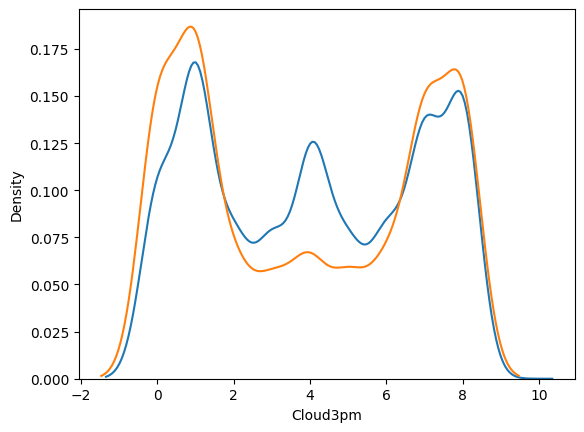

In [22]:
sns.kdeplot(df_entrenamiento["Cloud3pm"])
sns.kdeplot(df_entrenamiento["Cloud9am"])

Debido a la presencia de valores extremos en nuestras variables, decidimos utilizar la mediana para la imputación de datos nulos, ya que este enfoque proporciona una representación más confiable del 'valor central' y minimiza la influencia de los outliers en los resultados.

In [23]:
# Calcular la mediana en lugar de la media móvil en el conjunto de entrenamiento
cloud9am_median = df_entrenamiento['Cloud9am'].median()
cloud3pm_median = df_entrenamiento['Cloud3pm'].median()

df_entrenamiento['Cloud9am'] = df_entrenamiento['Cloud9am'].fillna(cloud9am_median)
df_entrenamiento['Cloud3pm'] = df_entrenamiento['Cloud3pm'].fillna(cloud3pm_median)

<Axes: xlabel='Cloud3pm', ylabel='Density'>

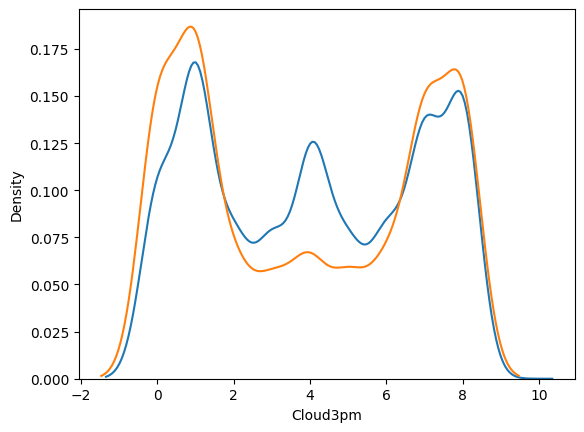

In [24]:
sns.kdeplot(df_entrenamiento["Cloud3pm"])
sns.kdeplot(df_entrenamiento["Cloud9am"])

In [25]:
nan_count_train = df_entrenamiento.isnull().sum()
nan_count_train

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

#### Outliers

In [26]:
resultados_atipicos = {}

for columna in df_entrenamiento.columns:
    if df_entrenamiento[columna].dtype in ['int64', 'float64']:
        Q1 = df_entrenamiento[columna].quantile(0.25)
        Q3 = df_entrenamiento[columna].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        es_atipico = (df_entrenamiento[columna] < limite_inferior) | (df_entrenamiento[columna] > limite_superior)

        cantidad_atipicos = es_atipico.sum()
        porcentaje_atipicos = (cantidad_atipicos / len(df_entrenamiento)) * 100

        resultados_atipicos[columna] = porcentaje_atipicos

for columna, porcentaje in resultados_atipicos.items():
    print(f"Columna: {columna} - Porcentaje de valores atípicos: {porcentaje:.2f}%")

Columna: Location - Porcentaje de valores atípicos: 22.40%
Columna: MinTemp - Porcentaje de valores atípicos: 0.19%
Columna: MaxTemp - Porcentaje de valores atípicos: 0.08%
Columna: Rainfall - Porcentaje de valores atípicos: 20.74%
Columna: Evaporation - Porcentaje de valores atípicos: 11.68%
Columna: Sunshine - Porcentaje de valores atípicos: 14.30%
Columna: WindGustSpeed - Porcentaje de valores atípicos: 1.69%
Columna: WindSpeed9am - Porcentaje de valores atípicos: 0.42%
Columna: WindSpeed3pm - Porcentaje de valores atípicos: 0.59%
Columna: Humidity9am - Porcentaje de valores atípicos: 0.00%
Columna: Humidity3pm - Porcentaje de valores atípicos: 0.18%
Columna: Pressure9am - Porcentaje de valores atípicos: 0.54%
Columna: Pressure3pm - Porcentaje de valores atípicos: 0.53%
Columna: Cloud9am - Porcentaje de valores atípicos: 0.00%
Columna: Cloud3pm - Porcentaje de valores atípicos: 0.00%
Columna: Temp9am - Porcentaje de valores atípicos: 0.41%
Columna: Temp3pm - Porcentaje de valores at

Observamos que en la mayoría de las columnas no hay una cantidad significativa de valores atípicos, por lo que decidimos no realizar ningún tratamiento sobre ellos.

A continuación, analizaremos la distribución de la variable objetivo.

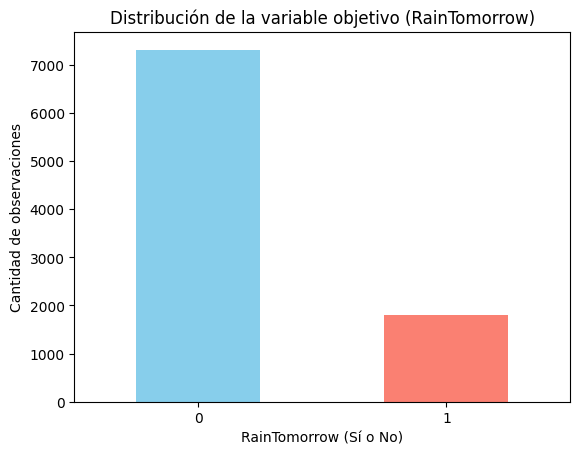

In [27]:
df_entrenamiento['RainTomorrow'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])

plt.title('Distribución de la variable objetivo (RainTomorrow)')
plt.xlabel('RainTomorrow (Sí o No)')
plt.ylabel('Cantidad de observaciones')
plt.xticks(rotation=0)
plt.show()


Observamos una marcada diferencia entre los dos valores de la variable objetivo, lo que indica que el conjunto de datos **está desbalanceado**, lo cual mas adelante procederemos a balancearlo. Además, es importante analizar la tasa de aciertos en las predicciones del dataset.

Predicción Acertada
True     6238
False    2883
Name: count, dtype: int64


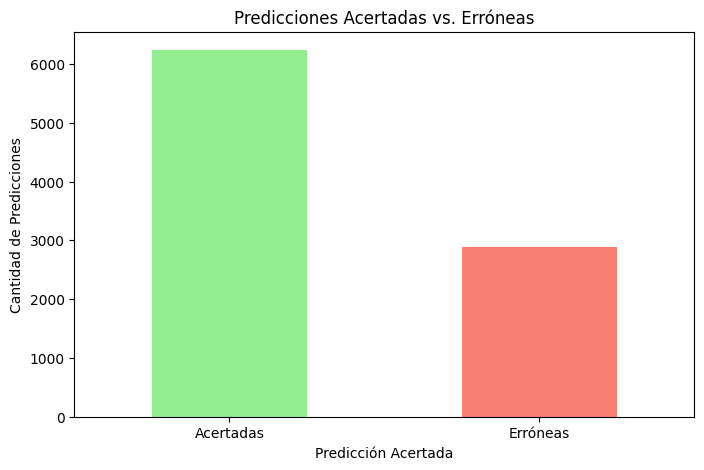

In [28]:
# Crear una copia de las columnas relevantes
df_aciertos = df_entrenamiento[['RainToday', 'RainTomorrow']].copy()

# Comparar RainToday de la fila actual con RainTomorrow de la fila anterior
# shift() mueve la columna RainTomorrow una fila hacia abajo
df_aciertos['Predicción Acertada'] = df_aciertos['RainToday'] == df_aciertos['RainTomorrow'].shift(1)

# Contar las predicciones acertadas y erróneas
conteo_aciertos = df_aciertos['Predicción Acertada'].value_counts()

# Mostrar conteo de aciertos
print(conteo_aciertos)

# Graficar los resultados
plt.figure(figsize=(8, 5))
conteo_aciertos.plot(kind='bar', color=['lightgreen', 'salmon'])

plt.title('Predicciones Acertadas vs. Erróneas')
plt.xlabel('Predicción Acertada')
plt.ylabel('Cantidad de Predicciones')
plt.xticks(ticks=[0, 1], labels=['Acertadas', 'Erróneas'], rotation=0)

plt.show()


Considerando la información proporcionada por las variables, analizamos la precisión de las 'predicciones' sobre si lloverá mañana. Observamos que se ha logrado una predicción con cierto grado de efectividad, aunque hay margen para mejorar.

### Matriz de correlación


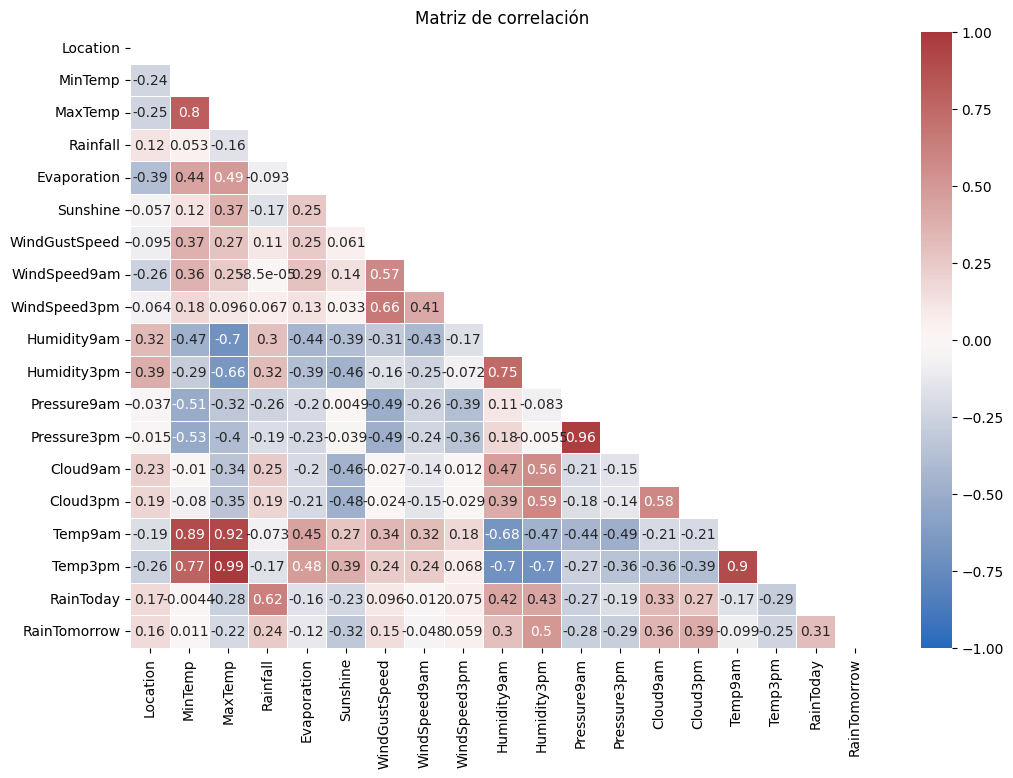

In [29]:
df_numerico = df_entrenamiento.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
corr_matrix = df_numerico.corr()

# Crear la máscara
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Crear el colormap
colors = [(1, 1, 1), (1, 0, 0)]
n_bins = 100
cmap_name = 'red_white'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Graficar el heatmap de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='vlag', center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()


Decidimos eliminar las columnas 'Temp9am' y 'Temp3pm', ya que contamos con 'MinTemp' y 'MaxTemp' para todo el día, y su correlación sugiere que son redundantes. De manera similar, considerando la correlación entre 'Pressure9am' y 'Pressure3pm', optamos por conservar solo una de ellas.

In [30]:
df_entrenamiento = df_entrenamiento.drop(columns=['Temp9am', 'Temp3pm', 'Pressure9am'])

### Limpieza de datos para df_test y df_validacion

Todas las imputaciones y limpiezas de datos que realizamos para el conjunto de entrenamiento también se aplicarán a los conjuntos de prueba y validación, asegurando consistencia en el procesamiento de los datos.

In [31]:
for col, media in medias.items():
    if col in df_validacion.columns:   
        df_validacion[col] = df_validacion[col].fillna(media)  
for col, media in medias.items():
    if col in df_test.columns:  
        df_test[col] = df_test[col].fillna(media)


df_test["Evaporation"] = df_test["Evaporation"].fillna(mediana_evaporation)
df_test["Sunshine"] = df_test["Sunshine"].fillna(mediana_sunshine)
df_validacion["Evaporation"] = df_validacion["Evaporation"].fillna(mediana_evaporation)
df_validacion["Sunshine"] = df_validacion["Sunshine"].fillna(mediana_sunshine)


df_test['Cloud9am'] = df_test['Cloud9am'].fillna(cloud9am_median)
df_test['Cloud3pm'] = df_test['Cloud3pm'].fillna(cloud3pm_median)
df_validacion['Cloud9am'] = df_validacion['Cloud9am'].fillna(cloud9am_median)
df_validacion['Cloud3pm'] = df_validacion['Cloud3pm'].fillna(cloud3pm_median)


df_test = df_test.drop(columns=['Temp9am', 'Temp3pm', 'Pressure9am'])
df_validacion = df_validacion.drop(columns=['Temp9am', 'Temp3pm', 'Pressure9am'])


Finalmente, para mejorar nuestras predicciones futuras, decidimos dividir la columna 'Date' en componentes como mes, día, año, día de la semana y día del año. No realizamos esta división anteriormente para evitar que se mostrara en la matriz de correlación.

In [32]:
# Extraer características de fecha para df_entrenamiento
df_entrenamiento['Year'] = df_entrenamiento['Date'].dt.year
df_entrenamiento['Month'] = df_entrenamiento['Date'].dt.month
df_entrenamiento['Day'] = df_entrenamiento['Date'].dt.day
df_entrenamiento['DayOfWeek'] = df_entrenamiento['Date'].dt.dayofweek  # Lunes = 0, Domingo = 6
df_entrenamiento['DayOfYear'] = df_entrenamiento['Date'].dt.dayofyear

# Extraer características de fecha para df_validacion
df_validacion['Year'] = df_validacion['Date'].dt.year
df_validacion['Month'] = df_validacion['Date'].dt.month
df_validacion['Day'] = df_validacion['Date'].dt.day
df_validacion['DayOfWeek'] = df_validacion['Date'].dt.dayofweek  # Lunes = 0, Domingo = 6
df_validacion['DayOfYear'] = df_validacion['Date'].dt.dayofyear

# Extraer características de fecha para df_test
df_test['Year'] = df_test['Date'].dt.year
df_test['Month'] = df_test['Date'].dt.month
df_test['Day'] = df_test['Date'].dt.day
df_test['DayOfWeek'] = df_test['Date'].dt.dayofweek  # Lunes = 0, Domingo = 6
df_test['DayOfYear'] = df_test['Date'].dt.dayofyear

# Dropear la columna 'Date' de df_entrenamiento
df_entrenamiento = df_entrenamiento.drop(columns=['Date'])

# Dropear la columna 'Date' de df_validacion
df_validacion = df_validacion.drop(columns=['Date'])

# Dropear la columna 'Date' de df_test
df_test = df_test.drop(columns=['Date'])

In [33]:
df_entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9121 entries, 108526 to 119107
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       9121 non-null   float64
 1   MinTemp        9121 non-null   float64
 2   MaxTemp        9121 non-null   float64
 3   Rainfall       9121 non-null   float64
 4   Evaporation    9121 non-null   float64
 5   Sunshine       9121 non-null   float64
 6   WindGustSpeed  9121 non-null   float64
 7   WindSpeed9am   9121 non-null   float64
 8   WindSpeed3pm   9121 non-null   float64
 9   Humidity9am    9121 non-null   float64
 10  Humidity3pm    9121 non-null   float64
 11  Pressure3pm    9121 non-null   float64
 12  Cloud9am       9121 non-null   float64
 13  Cloud3pm       9121 non-null   float64
 14  RainToday      9121 non-null   int64  
 15  RainTomorrow   9121 non-null   int64  
 16  Year           9121 non-null   int32  
 17  Month          9121 non-null   int32  
 18  Day   

## Escalado

Optamos por utilizar **RobustScaler** debido a que aún contamos con algunos valores atípicos. Esto permitirá que el algoritmo de aprendizaje automático sea más estable.

In [34]:
scaler = RobustScaler()

df_train_scaled = pd.DataFrame(scaler.fit_transform(df_entrenamiento), columns=df_entrenamiento.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)
df_val_scaled = pd.DataFrame(scaler.transform(df_validacion), columns=df_validacion.columns)

df_train_scaled.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,Year,Month,Day,DayOfWeek,DayOfYear
0,-5.626333,-0.206897,0.111111,0.0,-0.538462,0.00,-0.352941,0.000000,-0.307692,-0.59375,...,0.369565,0.014714,0.000000,0.0,0.0,1.0,-0.2,-0.266667,0.25,-0.260355
1,-0.739236,-0.459770,0.074074,0.0,0.000000,0.80,-0.588235,0.000000,-0.769231,0.43750,...,0.510870,0.348047,-0.016965,0.0,0.0,0.4,0.6,-0.066667,-0.75,0.485207
2,-0.739236,0.471264,0.435185,4.5,0.000000,0.00,-0.117647,0.153846,0.230769,0.21875,...,-0.652174,0.014714,-0.016965,1.0,0.0,-0.6,0.8,0.733333,-0.50,0.733728
3,0.000000,-0.919540,-0.787037,0.0,-1.461538,-4.60,1.705882,-1.153846,-0.923077,0.78125,...,-0.217391,0.681381,0.649702,0.0,1.0,-0.4,0.2,-0.200000,-0.50,0.106509
4,0.000000,0.137931,0.166667,1.0,-1.461538,-0.85,-0.882353,-0.692308,-0.769231,0.25000,...,0.413043,0.514714,0.149702,0.0,0.0,-1.0,1.0,0.533333,0.50,0.899408


## Modelado

In [35]:
X_train_scaled = df_train_scaled.drop('RainTomorrow', axis=1)
y_train_scaled = df_train_scaled['RainTomorrow']

X_test_scaled = df_test_scaled.drop('RainTomorrow', axis=1)
y_test_scaled = df_test_scaled['RainTomorrow']

X_val_scaled = df_val_scaled.drop('RainTomorrow', axis=1)
y_val_scaled = df_val_scaled['RainTomorrow']

### Previo al balanceo

Vamos a evaluar las métricas del dataset antes de balancearlo. Luego, realizaremos el balanceo y compararemos los resultados.

Aplicamos 'LogisticRegression'

In [36]:
# Inicializar y entrenar el modelo
model = LogisticRegression()
model.fit(X_train_scaled, y_train_scaled)

LogisticRegression()

Procedemos a calcular nuestras métricas adecuadas.

In [37]:
# Predicciones
y_pred = model.predict(X_test_scaled)  
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Cálculo de métricas
accuracy = accuracy_score(y_test_scaled, y_pred)
precision = precision_score(y_test_scaled, y_pred)
recall = recall_score(y_test_scaled, y_pred)
f1 = f1_score(y_test_scaled, y_pred)

# Mostrar las métricas
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.87
Precision: 0.75
Recall: 0.54
F1 Score: 0.63


Calculamos nuestra curva ROC

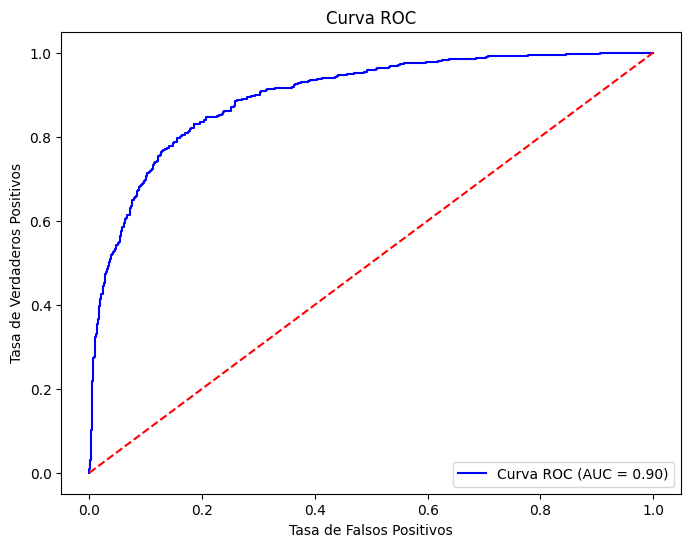

Mejor umbral: 0.20


In [38]:
# Cálculo de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_scaled, y_pred_proba)
roc_auc = roc_auc_score(y_test_scaled, y_pred_proba)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Encontrar el mejor umbral
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Mejor umbral: {optimal_threshold:.2f}")

Verificamos la matriz de confusión

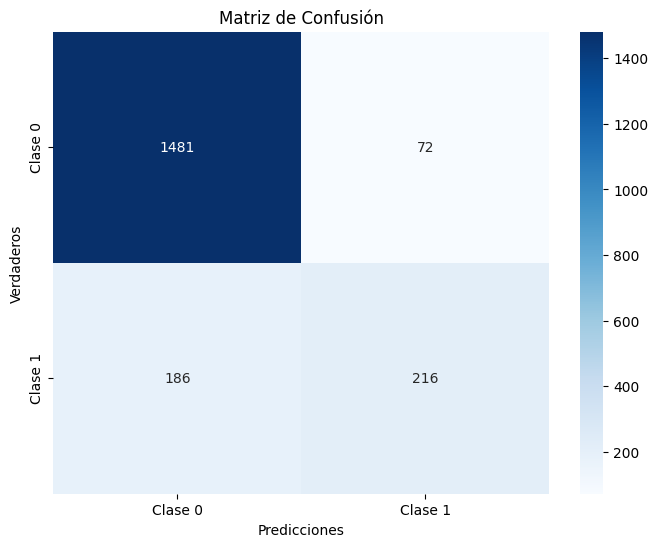

In [39]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test_scaled, y_pred)
# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 0', 'Clase 1'], 
            yticklabels=['Clase 0', 'Clase 1'])
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()

### Posterior al balanceo

Aplicamos SMOTE para balancear las clases ya que este metodo 

In [40]:
# Aplicar SMOTE para balancear la clase minoritaria
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_scaled)


Verificamos que se haya balanceado correctamente.

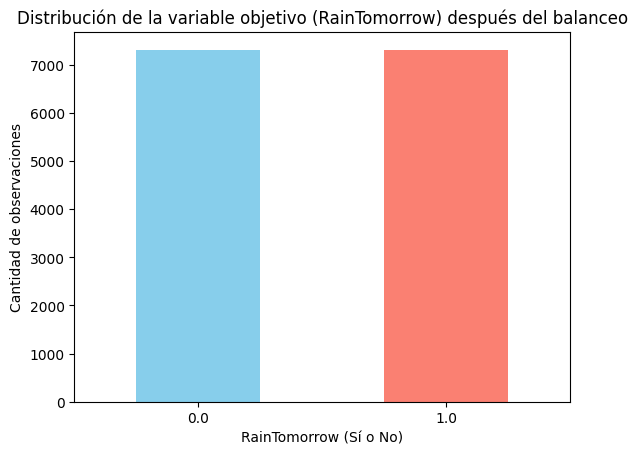

In [41]:
# Crear un dataframe con los datos balanceados
df_balanceado = pd.DataFrame({'RainTomorrow': y_train_balanced})

# Graficar la nueva distribución
df_balanceado['RainTomorrow'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])

plt.title('Distribución de la variable objetivo (RainTomorrow) después del balanceo')
plt.xlabel('RainTomorrow (Sí o No)')
plt.ylabel('Cantidad de observaciones')
plt.xticks(rotation=0)
plt.show()


In [42]:
# Inicializar y entrenar el modelo
model_logistic = LogisticRegression()
model_logistic.fit(X_train_balanced, y_train_balanced)

LogisticRegression()

In [43]:
# Predicciones
y_pred_logistic = model_logistic.predict(X_test_scaled)  
y_pred_proba_logistic = model_logistic.predict_proba(X_test_scaled)[:, 1]

# Cálculo de métricas
accuracy_logistic = accuracy_score(y_test_scaled, y_pred_logistic)
precision_logistic = precision_score(y_test_scaled, y_pred_logistic)
recall_logistic = recall_score(y_test_scaled, y_pred_logistic)
f1_logistic = f1_score(y_test_scaled, y_pred_logistic)

# Mostrar las métricas
print(f"Accuracy: {accuracy_logistic:.2f}")
print(f"Precision: {precision_logistic:.2f}")
print(f"Recall: {recall_logistic:.2f}")
print(f"F1 Score: {f1_logistic:.2f}")



Accuracy: 0.82
Precision: 0.53
Recall: 0.83
F1 Score: 0.65


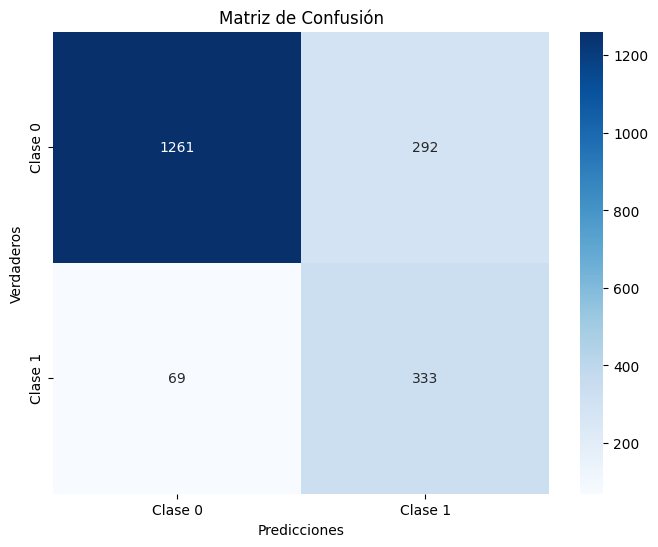

In [44]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test_scaled, y_pred_logistic)
# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 0', 'Clase 1'], 
            yticklabels=['Clase 0', 'Clase 1'])
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()

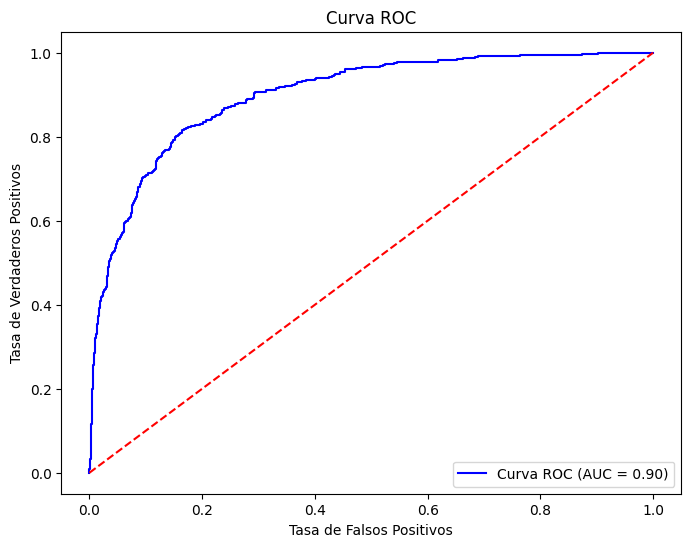

Mejor umbral: 0.54


In [45]:
# Cálculo de la curva ROC
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test_scaled, y_pred_proba_logistic)
roc_auc_logistic = roc_auc_score(y_test_scaled, y_pred_proba_logistic)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_logistic, tpr_logistic, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc_logistic))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Encontrar el mejor umbral
optimal_idx_logistic = np.argmax(tpr_logistic - fpr_logistic)
optimal_threshold_logistic = thresholds_logistic[optimal_idx_logistic]
print(f"Mejor umbral: {optimal_threshold_logistic:.2f}")


Al evaluar el modelo antes de balancear los datos, se observaron métricas que indicaban un buen rendimiento general, con un nivel aceptable de precisión. Sin embargo, esto nos podria decir que el modelo podría haber estado sesgado hacia la clase mayoritaria, dado que el recall no era tan alto.

Después de implementar el balanceo de los datos, las métricas mostraron un gran cambio. Aunque la precisión disminuyó, el recall aumentó. Esto indica que, tras el balanceo, el modelo es capaz de identificar mejor los casos de la clase minoritaria, pero esto tuvo un costo en la precisión. La puntuación F1 se mantuvo constante, por lo que el modelo logró un equilibrio en su capacidad para detectar ambas clases.

La nueva matriz de confusión refleja este cambio: aunque el número de verdaderos positivos aumentó, también se observó un aumento en los falsos positivos. El cambio en el umbral óptimo también refleja esta transición, diciendonos que el modelo ahora necesita un ajuste diferente para lograr el equilibrio deseado entre las clases. Por lo tanto, el balanceo de datos mejoró la capacidad del modelo para identificar casos de la clase minoritaria, aunque a expensas de la precisión general.

## Modelo Base

Para nuestro modelo base, decidimos utilizar el **DummyClassifier** con la estrategia "stratified". A continuación, procederemos a realizar los mismos pasos que en el modelo anterior, evaluando tanto el modelo base balanceado como el desbalanceado.

### Previo al balanceo

In [46]:
# Inicializar el DummyClassifier con la estrategia 'stratified'
dummy_clf_stratified = DummyClassifier(strategy='stratified', random_state=42)

# Entrenar el modelo Dummy
dummy_clf_stratified.fit(X_train_scaled, y_train_scaled)

# Predecir probabilidades en lugar de clases
y_pred_dummy_proba = dummy_clf_stratified.predict_proba(X_test_scaled)[:, 1]  # Probabilidades de la clase positiva

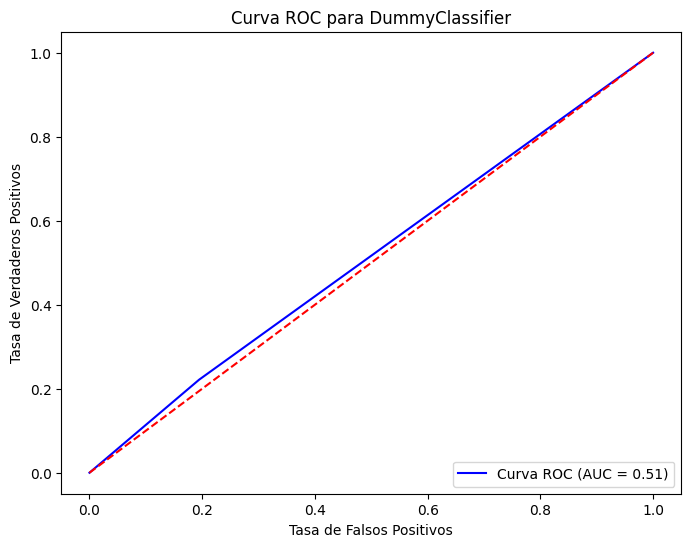

In [47]:
# Calcular la curva ROC y encontrar el AUC
fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(y_test_scaled, y_pred_dummy_proba)
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_dummy, tpr_dummy, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc_dummy))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para DummyClassifier')
plt.legend(loc='lower right')
plt.show()

In [48]:
# Encontrar el mejor umbral
optimal_idx_dummy = np.argmax(tpr_dummy - fpr_dummy)  # Mejor umbral donde TPR - FPR es máximo
optimal_threshold_dummy = thresholds_dummy[optimal_idx_dummy]

print(f"Mejor umbral: {optimal_threshold:.2f}")

Mejor umbral: 0.20


In [49]:
# Calcular métricas con las clases generadas por el umbral óptimo
accuracy_dummy = accuracy_score(y_test_scaled, y_pred_dummy_proba)
precision_dummy = precision_score(y_test_scaled, y_pred_dummy_proba)
recall_dummy = recall_score(y_test_scaled, y_pred_dummy_proba)
f1_dummy = f1_score(y_test_scaled, y_pred_dummy_proba)

print("\nMétricas con DummyClassifier:")
print(f"Accuracy: {accuracy_dummy:.2f}")
print(f"Precision: {precision_dummy:.2f}")
print(f"Recall: {recall_dummy:.2f}")
print(f"F1 Score: {f1_dummy:.2f}")


Métricas con DummyClassifier:
Accuracy: 0.69
Precision: 0.23
Recall: 0.22
F1 Score: 0.22


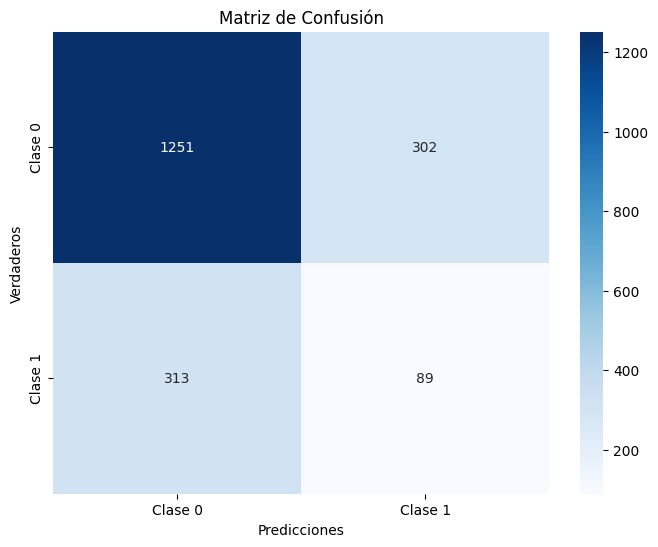

In [50]:
# Matriz de confusión
conf_matrix_dummy = confusion_matrix(y_test_scaled, y_pred_dummy_proba)
# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dummy, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 0', 'Clase 1'], 
            yticklabels=['Clase 0', 'Clase 1'])
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()

### Posterior al balanceo

In [51]:
# Inicializar el DummyClassifier con la estrategia 'stratified'
dummy_clf_stratified_balanced = DummyClassifier(strategy='stratified', random_state=42)

# Entrenar el modelo Dummy
dummy_clf_stratified_balanced.fit(X_train_balanced, y_train_balanced)

# Predecir probabilidades en lugar de clases
y_pred_dummy_proba_balanced = dummy_clf_stratified_balanced.predict_proba(X_test_scaled)[:, 1]  # Probabilidades de la clase positiva

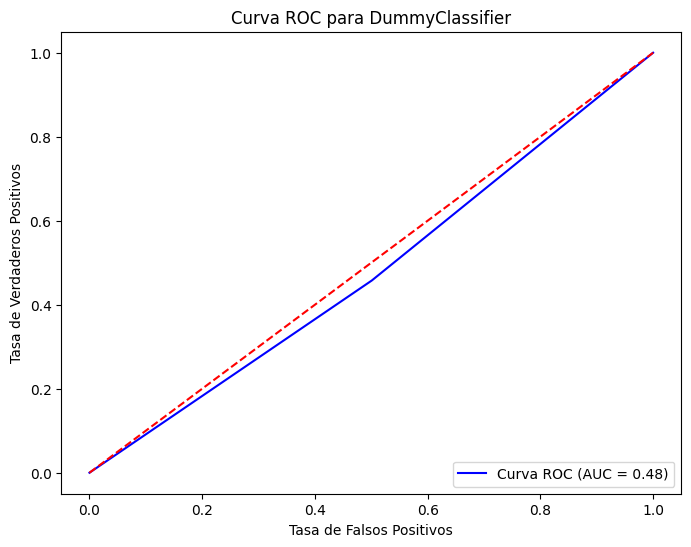

In [52]:
# Calcular la curva ROC y encontrar el AUC
fpr_dummy_balanced, tpr_dummy_balanced, thresholds_dummy_balanced = roc_curve(y_test_scaled, y_pred_dummy_proba_balanced)
roc_auc_dummy_balanced = auc(fpr_dummy_balanced, tpr_dummy_balanced)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_dummy_balanced, tpr_dummy_balanced, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc_dummy_balanced))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para DummyClassifier')
plt.legend(loc='lower right')
plt.show()

In [53]:
# Encontrar el mejor umbral
optimal_idx_dummy_balanced = np.argmax(tpr_dummy_balanced - fpr_dummy_balanced)  # Mejor umbral donde TPR - FPR es máximo
optimal_threshold_dummy_balanced = thresholds_dummy_balanced[optimal_idx_dummy_balanced]

print(f"Mejor umbral: {optimal_threshold_dummy_balanced:.2f}")

Mejor umbral: inf


In [54]:
# Calcular métricas con las clases generadas por el umbral óptimo
accuracy_dummy_balanced= accuracy_score(y_test_scaled, y_pred_dummy_proba_balanced)
precision_dummy_balanced = precision_score(y_test_scaled, y_pred_dummy_proba_balanced)
recall_dummy_balanced = recall_score(y_test_scaled, y_pred_dummy_proba_balanced)
f1_dummy_balanced = f1_score(y_test_scaled, y_pred_dummy_proba_balanced)

print("\nMétricas con DummyClassifier:")
print(f"Accuracy: {accuracy_dummy_balanced:.2f}")
print(f"Precision: {precision_dummy_balanced:.2f}")
print(f"Recall: {recall_dummy_balanced:.2f}")
print(f"F1 Score: {f1_dummy_balanced:.2f}")




Métricas con DummyClassifier:
Accuracy: 0.49
Precision: 0.19
Recall: 0.46
F1 Score: 0.27


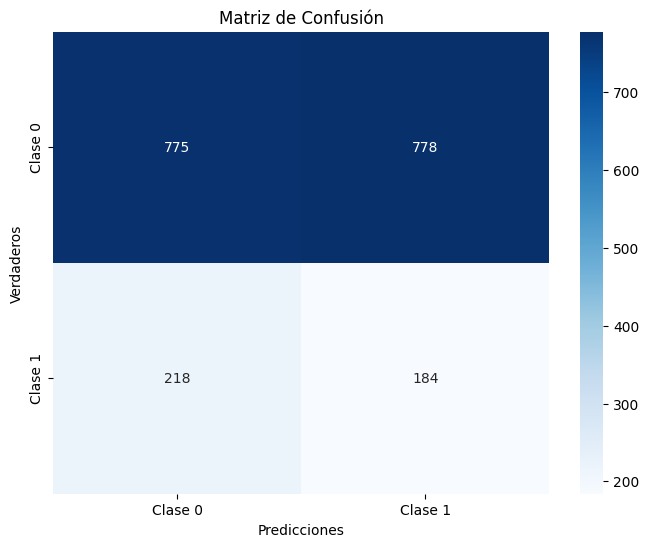

In [55]:
# Matriz de confusión
conf_matrix_dummy_balanced = confusion_matrix(y_test_scaled, y_pred_dummy_proba_balanced)
# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dummy_balanced, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 0', 'Clase 1'], 
            yticklabels=['Clase 0', 'Clase 1'])
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()


Al evaluar el modelo base utilizando el **DummyClassifier** con la estrategia **"stratified"** antes de balancear los datos, las métricas indicaron un rendimiento limitado. La precisión y el recall fueron bajos, interpretando que el modelo tenía dificultades para identificar correctamente las instancias de la clase positiva. La matriz de confusión reveló que el modelo estaba prediciendo en gran medida la clase mayoritaria, lo que se refleja en el umbral óptimo, que era de 1.00.

Después de balancear los datos, se observó una disminución en la precisión general del modelo base, lo que indica que, aunque el recall mejoró, el modelo seguía sin ser efectivo en la identificación de la clase positiva. La puntuación F1 también mostró una leve mejora, pero las métricas siguieron indicando un rendimiento subóptimo. El umbral óptimo se mantuvo en 1.00, lo que refuerza que el modelo no estaba capturando adecuadamente la clase minoritaria, incluso después del balanceo.


## Optimización de hiperparametros


Decidimos utilizar `Random Search` porque es ideal para nuestro caso, ya que contamos con un gran volumen de datos. Esta técnica selecciona combinaciones de hiperparámetros de manera aleatoria, lo cual nos permite explorar un amplio rango del espacio de búsqueda sin probar todas las combinaciones posibles. Además, `Random Search` ofrece resultados eficientes en menos tiempo cuando el rango de los hiperparámetros es amplio y no conocemos de antemano los valores óptimos.


In [75]:
param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],  
    'solver': ['lbfgs', 'liblinear', 'saga'], 
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [100, 200, 500],
    'tol': [0.0001, 0.001, 0.01],
    'fit_intercept': [True, False],
    'class_weight': ['balanced'],
    'l1_ratio': [0.5, 0.7]  # solo se usa cuando la penalidad es 'elasticnet'
}


# Configura el modelo con RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=LogisticRegression(),
                                   param_distributions=param_grid,
                                   n_iter=10,                   # Número de combinaciones a probar
                                   scoring='f1',                # Métrica para optimizar
                                   cv=5,                        # Número de pliegues de validación cruzada
                                   random_state=42)

# Entrena el RandomizedSearchCV
random_search.fit(X_train_balanced, y_train_balanced)

# Obtén el mejor modelo encontrado
best_logistic_model = random_search.best_estimator_

# Usa el mejor modelo para hacer predicciones
y_pred_logistic = best_logistic_model.predict(X_test_scaled)
y_pred_proba_logistic = best_logistic_model.predict_proba(X_test_scaled)[:, 1]

# Calcula las métricas
accuracy_logistic = accuracy_score(y_test_scaled, y_pred_logistic)
precision_logistic = precision_score(y_test_scaled, y_pred_logistic)
recall_logistic = recall_score(y_test_scaled, y_pred_logistic)
f1_logistic = f1_score(y_test_scaled, y_pred_logistic)

# Muestra las métricas
print(f"Mejores parámetros: {random_search.best_params_}")
print(f"Accuracy: {accuracy_logistic:.2f}")
print(f"Precision: {precision_logistic:.2f}")
print(f"Recall: {recall_logistic:.2f}")
print(f"F1 Score: {f1_logistic:.2f}")



c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\franco\Ap

Mejores parámetros: {'tol': 0.0001, 'solver': 'saga', 'penalty': 'l2', 'max_iter': 100, 'l1_ratio': 0.5, 'fit_intercept': True, 'class_weight': 'balanced', 'C': 0.1}
Accuracy: 0.81
Precision: 0.52
Recall: 0.84
F1 Score: 0.64


**Antes de la optimización de los hiperparámetros**:
- *Accuracy*: 0.82
- *Precision*: 0.53
- *Recall*: 0.83
- *F1 Score*: 0.65

**Después de la optimización de los hiperparámetros** (con los mejores parámetros encontrados: {'tol': 0.0001, 'solver': 'saga', 'penalty': 'l2', 'max_iter': 100, 'l1_ratio': 0.5, 'fit_intercept': True, 'class_weight': 'balanced', 'C': 0.1})
- *Accuracy*: 0.81
- *Precision*: 0.52
- *Recall*: 0.84
- *F1 Score*: 0.64

### Análisis de Resultados

La optimización de los hiperparámetros ha mejorado muy poco el *recall*, que pasó de 0.83 a 0.84, aumentando la capacidad del modelo para detectar instancias positivas. Sin embargo, el *accuracy* cayó de 0.82 a 0.81, al igual que la *precision*, que ha bajado de 0.53 a 0.52, lo que indica que el modelo es ahora menos preciso al identificar correctamente las instancias positivas.

El *F1 Score* se también bajó minimamente, pasando de 0.65 a 0.64, reflejando un balance similar entre *precision* y *recall*. 

Aunque el nuevo modelo presenta una leve mejora en el *recall*, el modelo original podría seguir siendo preferible debido a su mayor *accuracy* y *precision*.

## SHAP

### Local

In [164]:
feature_names=df_clima.drop('RainTomorrow', axis=1).columns.values
# Crea un objeto explainer SHAP
explainer = shap.LinearExplainer(model, X_train_balanced, feature_names=feature_names)
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_scaled)
index=2

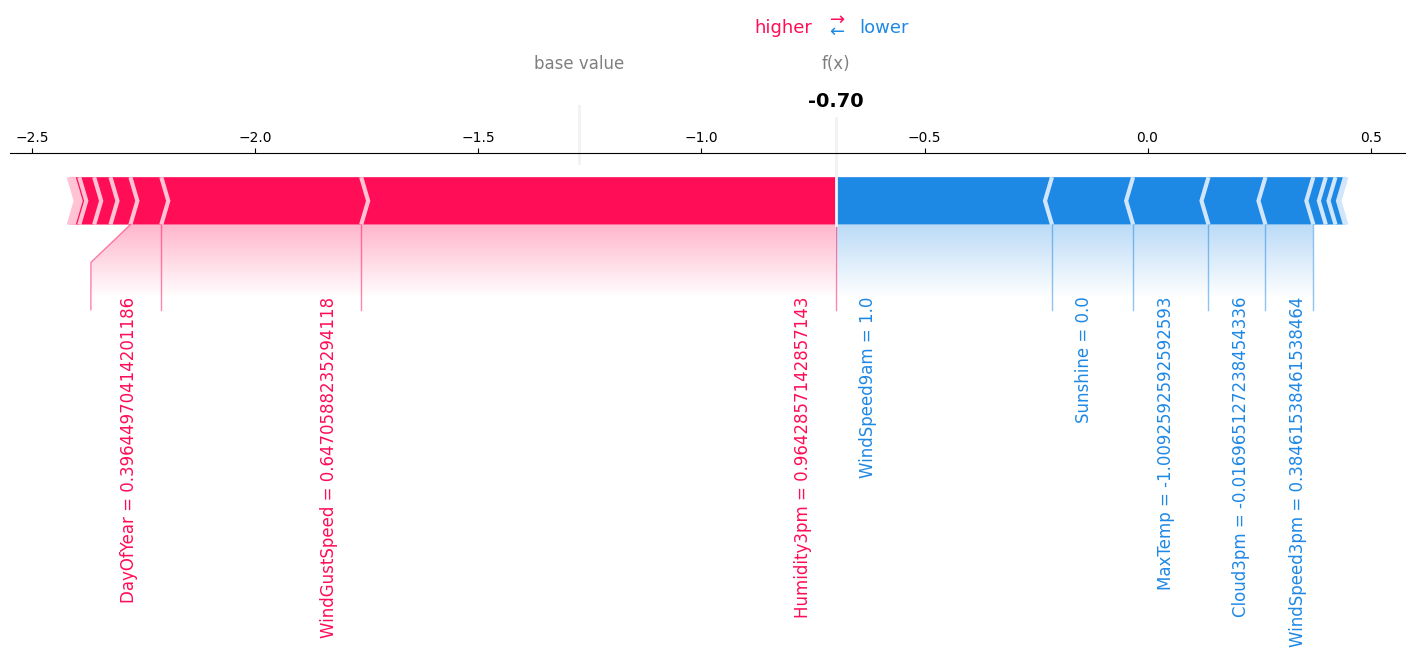

In [165]:
shap.force_plot(explainer.expected_value, shap_values[index],
                X_test_scaled.iloc[index],
                matplotlib=True, figsize=(18, 4), text_rotation=90)

1. **Valor de Predicción Final (f(x))**:
   - El valor final de la predicción es `-0.70`, que es el resultado después de considerar todas las contribuciones de las características de este caso específico.

2. **Valor Base**:
   - El "valor base" es el punto inicial, representado en el centro de la escala. Es el promedio de las predicciones del modelo para todos los datos, antes de tomar en cuenta las características de este caso en particular.

3. **Características que Incrementan la Predicción (en rojo)**:
   - `Humidity3pm = 0.9643`: La humedad a las 3 pm tiene la mayor contribución positiva, empujando la predicción hacia arriba.
   - `WindGustSpeed = 0.6471`: La velocidad de ráfagas de viento también tiene un efecto positivo significativo.
   - `DayOfYear = 0.3964`: El día del año también contribuye, aunque en menor medida, a incrementar el valor de la predicción.

   Estas características en rojo están empujando el valor final hacia arriba, contribuyendo positivamente a la predicción de `-0.70`.

4. **Características que Disminuyen la Predicción (en azul)**:
   - `MaxTemp = -1.0093`: La temperatura máxima tiene la mayor contribución negativa, reduciendo significativamente el valor de la predicción.
   - `WindSpeed9am = 1.0`: La velocidad del viento a las 9 am también tiene un efecto negativo notable, disminuyendo la predicción.
   - `Cloud3pm = -0.0197` y `WindSpeed3pm = -0.3846`: La cantidad de nubes a las 3 pm y la velocidad del viento a las 3 pm también contribuyen a reducir la predicción, aunque en menor medida.

5. **Interpretación Global**:
   - En este caso, la predicción final se ve afectada por un conjunto de características donde la `Humidity3pm`, `WindGustSpeed`, y el `DayOfYear` impulsan la predicción hacia arriba, mientras que la `MaxTemp` y la `WindSpeed9am` la reducen de forma significativa.
   - Las características en rojo representan factores que el modelo asocia con un valor de predicción más alto en este contexto, mientras que las características en azul están asociadas con un valor de predicción más bajo.

En conjunto, este gráfico de SHAP muestra que las condiciones de humedad y velocidad de viento en este día específico incrementan la predicción, mientras que la temperatura y otros factores climáticos, como la nubosidad y la velocidad del viento en la mañana, la reducen.

In [166]:
explanation = shap.Explanation(values=shap_values[index],
                               base_values=explainer.expected_value,
                               feature_names=feature_names)


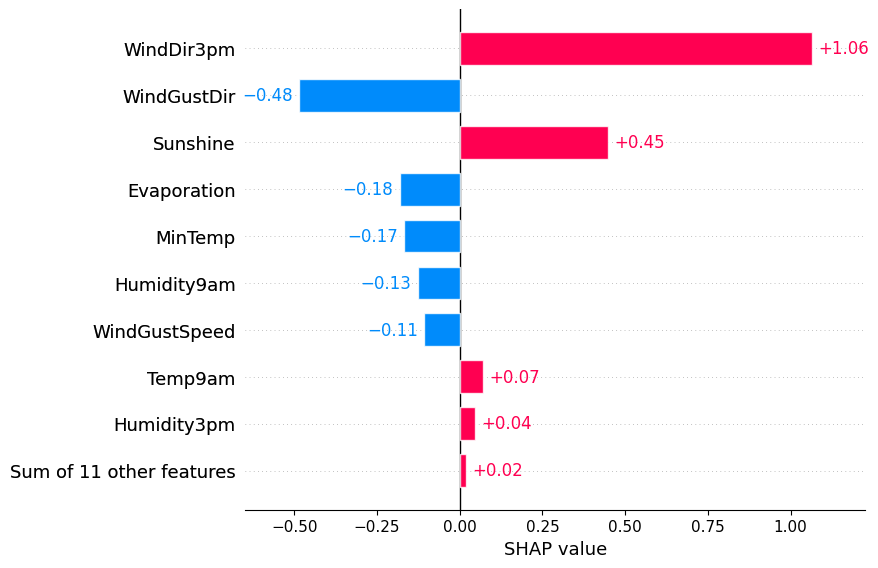

In [167]:
shap.plots.bar(explanation)


### Global

In [168]:
explanation_global = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test_scaled)

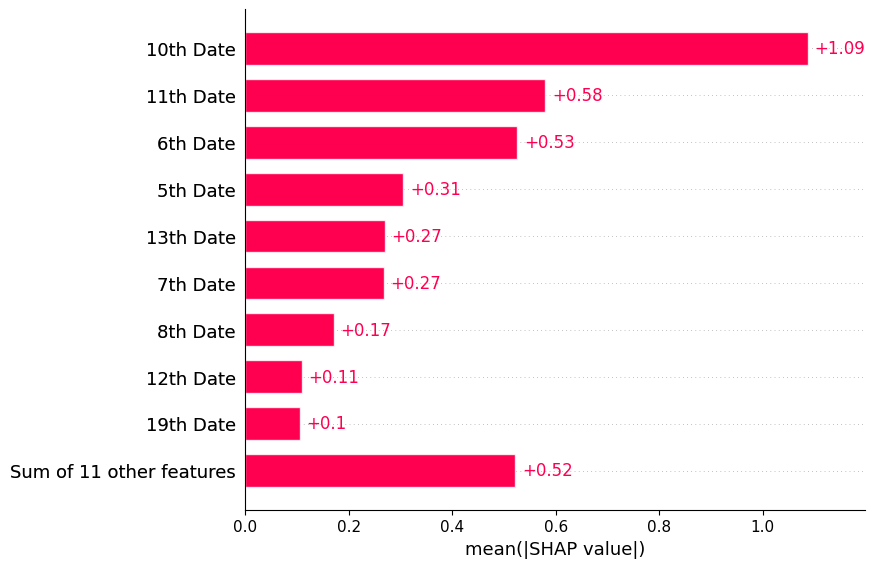

In [169]:
shap.plots.bar(explanation_global)

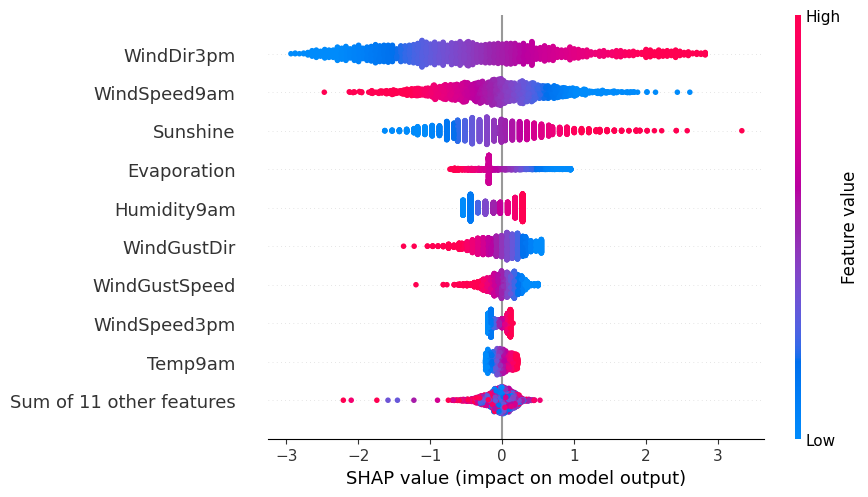

In [170]:
shap.plots.beeswarm(explanation_global)

## MLOPs

In [58]:

"""# Configurar el modelo de AutoML
tpot = TPOTClassifier(generations=5, population_size=20, cv=5, random_state=24, verbosity=2)

# Entrenar el modelo
tpot.fit(X_train_balanced, y_train_balanced)

# Realizar predicciones sobre el conjunto de prueba
y_pred_mlops = tpot.predict(X_test_scaled)

# Evaluar el modelo con diferentes métricas
accuracy_mlops = accuracy_score(y_test, y_pred)
precision_mlops = precision_score(y_test, y_pred, average='weighted')  # Usamos 'weighted' para clasificación multiclase
recall_mlops = recall_score(y_test, y_pred, average='weighted')
f1_mlops = f1_score(y_test, y_pred, average='weighted')

# Imprimir las métricas
print("Accuracy:", accuracy_mlops)
print("Precisión:", precision_mlops)
print("Recall:", recall_mlops)
print("F1 Score:", f1_mlops)

# También puedes mostrar un informe más detallado con classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlops))

# Exportar el pipeline óptimo encontrado
tpot.export('pipeline_optimo.py')
"""

'# Configurar el modelo de AutoML\ntpot = TPOTClassifier(generations=5, population_size=20, cv=5, random_state=24, verbosity=2)\n\n# Entrenar el modelo\ntpot.fit(X_train_balanced, y_train_balanced)\n\n# Realizar predicciones sobre el conjunto de prueba\ny_pred_mlops = tpot.predict(X_test_scaled)\n\n# Evaluar el modelo con diferentes métricas\naccuracy_mlops = accuracy_score(y_test, y_pred)\nprecision_mlops = precision_score(y_test, y_pred, average=\'weighted\')  # Usamos \'weighted\' para clasificación multiclase\nrecall_mlops = recall_score(y_test, y_pred, average=\'weighted\')\nf1_mlops = f1_score(y_test, y_pred, average=\'weighted\')\n\n# Imprimir las métricas\nprint("Accuracy:", accuracy_mlops)\nprint("Precisión:", precision_mlops)\nprint("Recall:", recall_mlops)\nprint("F1 Score:", f1_mlops)\n\n# También puedes mostrar un informe más detallado con classification_report\nprint("\nClassification Report:")\nprint(classification_report(y_test, y_pred_mlops))\n\n# Exportar el pipeline 

### Interpretación de los Resultados de TPOT

El proceso de TPOT ha realizado una optimización de modelos automáticos durante cinco generaciones, buscando mejorar el puntaje de validación cruzada (*CV score*). A continuación se muestra un análisis de los resultados y del mejor modelo encontrado.

1. **Evolución de las Generaciones**:
   - La puntuación interna de validación cruzada (*CV score*) fue mejorando en las primeras dos generaciones, alcanzando un máximo de 0.9061 en la segunda generación. Desde entonces, el modelo no logró superar este puntaje en las siguientes generaciones (3, 4 y 5), sugiriendo que TPOT encontró un máximo local en términos de desempeño.

2. **Mejor Pipeline Encontrado**:
   - El mejor pipeline consiste en una combinación de un **RandomForestClassifier** seguido por un **MLPClassifier** (clasificador de perceptrón multicapa). Este pipeline utiliza los siguientes hiperparámetros:
     - **RandomForestClassifier**: `criterion=entropy`, `max_features=0.45`, `min_samples_leaf=11`, `min_samples_split=19`, `n_estimators=100`.
     - **MLPClassifier**: `alpha=0.0001`, `learning_rate_init=0.01`.

3. **Métricas del Modelo Final en el Conjunto de Prueba**:
   - **Accuracy**: 0.8680
   - **Precisión**: 0.8600
   - **Recall**: 0.8680
   - **F1 Score**: 0.8595

   Estas métricas reflejan el rendimiento del modelo en general. Un *accuracy* de 0.8680 indica que el modelo clasifica correctamente el 86.8% de las instancias en el conjunto de prueba.

4. **Análisis Detallado por Clase**:
   - Clase 0 (etiqueta negativa):
     - **Precisión**: 0.91, **Recall**: 0.91, **F1 Score**: 0.91. La clase 0 tiene un buen balance de precisión y recall, con un F1-score alto. Esto sugiere que el modelo identifica correctamente la mayoría de las instancias de la clase negativa.
   - Clase 1 (etiqueta positiva):
     - **Precisión**: 0.65, **Recall**: 0.66, **F1 Score**: 0.65. La clase 1 muestra un rendimiento más bajo en comparación con la clase 0, lo cual es común en situaciones donde la clase positiva es minoritaria. Esto indica que el modelo tiene dificultades para detectar instancias de la clase positiva de forma precisa y exhaustiva.

5. **Promedios Macro y Ponderado**:
   - **Macro Avg**: La media macro para precisión, recall y F1-score es de 0.78, lo que indica un balance general moderado entre las clases, pero con una penalización debido al menor rendimiento en la clase positiva.
   - **Weighted Avg**: El promedio ponderado para precisión, recall y F1-score es de 0.86, reflejando un desempeño alto en general, aunque sigue destacando la dificultad del modelo con la clase positiva.


El modelo optimizado por TPOT ofrece un buen desempeño general, especialmente en la clase mayoritaria (0), lo cual contribuye a un *accuracy* alto. Sin embargo, tiene dificultades con la clase minoritaria (1), donde el recall y la precisión son más bajos.
